In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

np.random.seed(42)
N_TIMESTEPS = 20000  # ~14 days at 1-minute resolution
FREQ = '1min'        # 1 timestep = 1 minute

start_time = datetime(2026, 1, 1, 0, 0, 0)
timestamps = pd.date_range(start=start_time, periods=N_TIMESTEPS, freq=FREQ)

print(f"Dataset coverage: {timestamps[0]} to {timestamps[-1]}")
print(f"Total duration: {(timestamps[-1] - timestamps[0]).days} days, {(timestamps[-1] - timestamps[0]).seconds // 3600} hours")

Dataset coverage: 2026-01-01 00:00:00 to 2026-01-14 21:19:00
Total duration: 13 days, 21 hours


In [13]:
import numpy as np
import pandas as pd

def generate_base_pattern(
    n_timesteps,
    trend_per_day=0.0,
    baseline=50.0,
    daily_amplitude=15.0,
    hourly_amplitude=5.0
):
    t = np.arange(n_timesteps, dtype=float)

    # trend_per_day -> per minute
    trend = (trend_per_day / 1440.0) * t

    daily_cycle = daily_amplitude * np.sin(2 * np.pi * t / 1440.0)
    hourly_cycle = hourly_amplitude * np.sin(2 * np.pi * t / 60.0)

    return baseline + trend + daily_cycle + hourly_cycle


def generate_heavy_tailed_noise(n_timesteps, scale=2.0, df=3, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    return rng.standard_t(df=df, size=n_timesteps) * scale


def generate_metric(
    n_timesteps,
    metric_name,
    baseline,
    trend_per_day,
    daily_amp,
    hourly_amp,
    noise_scale,
    revert=0.15,
    seed=None
):
    """
    Mean-reverting synthetic metric:
    x[t] = x[t-1] + revert*(pattern[t] - x[t-1]) + heavy_tail_noise[t]
    """
    rng = np.random.default_rng(seed)

    pattern = generate_base_pattern(
        n_timesteps,
        trend_per_day=trend_per_day,
        baseline=baseline,
        daily_amplitude=daily_amp,
        hourly_amplitude=hourly_amp
    )

    noise = generate_heavy_tailed_noise(n_timesteps, scale=noise_scale, df=3, rng=rng)

    x = np.empty(n_timesteps, dtype=float)
    x[0] = pattern[0] + noise[0]

    for i in range(1, n_timesteps):
        x[i] = x[i-1] + revert * (pattern[i] - x[i-1]) + noise[i]

    # clipping
    if metric_name in ["cpu_utilization", "memory_usage", "error_rate"]:
        x = np.clip(x, 0, 100)
    else:
        x = np.clip(x, 0, None)

    return x


def generate_memory_leak_with_gc(
    n_timesteps,
    baseline=65.0,
    leak_per_day=2.0,
    noise_scale=0.6,
    revert=0.20,
    gc_interval_min=(360, 900),
    gc_drop_range=(10, 25),
    daily_amp=6.0,
    hourly_amp=2.0,
    seed=None
):
    rng = np.random.default_rng(seed)

    pattern = generate_base_pattern(
        n_timesteps,
        trend_per_day=0.0,
        baseline=baseline,
        daily_amplitude=daily_amp,
        hourly_amplitude=hourly_amp
    )
    noise = generate_heavy_tailed_noise(n_timesteps, scale=noise_scale, df=3, rng=rng)

    x = np.empty(n_timesteps, dtype=float)
    x[0] = pattern[0] + noise[0]

    leak_per_min = leak_per_day / 1440.0

    next_gc = int(rng.integers(gc_interval_min[0], gc_interval_min[1]))

    for i in range(1, n_timesteps):
        x[i] = x[i-1] + revert * (pattern[i] - x[i-1]) + noise[i] + leak_per_min

        if i == next_gc:
            drop = float(rng.uniform(gc_drop_range[0], gc_drop_range[1]))
            x[i] = x[i] - drop
            next_gc = i + int(rng.integers(gc_interval_min[0], gc_interval_min[1]))

    return np.clip(x, 0, 100)


metrics_config = {
    "cpu_utilization": {
        "baseline": 50.0,
        "trend_per_day": 0.0,
        "daily_amp": 15.0,
        "hourly_amp": 5.0,
        "noise_scale": 1.0,
        "revert": 0.15
    },
    "memory_usage": {
    },
    "request_latency": {
        "baseline": 150.0,
        "trend_per_day": 0.0,
        "daily_amp": 25.0,
        "hourly_amp": 8.0,
        "noise_scale": 3.0,
        "revert": 0.12
    },
    "error_rate": {
        "baseline": 0.8,
        "trend_per_day": 0.0,
        "daily_amp": 0.2,
        "hourly_amp": 0.1,
        "noise_scale": 0.2,
        "revert": 0.25
    },
    "request_rate": {
        "baseline": 1000.0,
        "trend_per_day": 0.0,
        "daily_amp": 350.0,
        "hourly_amp": 90.0,
        "noise_scale": 40.0,
        "revert": 0.12
    }
}

df = pd.DataFrame({"timestamp": timestamps})

for metric_name, cfg in metrics_config.items():
    if metric_name == "memory_usage":
        df[metric_name] = generate_memory_leak_with_gc(
            N_TIMESTEPS,
            baseline=65.0,
            leak_per_day=2.0,
            noise_scale=0.6,
            revert=0.20,
            seed=123
        )
    else:
        df[metric_name] = generate_metric(
            N_TIMESTEPS,
            metric_name,
            baseline=cfg["baseline"],
            trend_per_day=cfg["trend_per_day"],
            daily_amp=cfg["daily_amp"],
            hourly_amp=cfg["hourly_amp"],
            noise_scale=cfg["noise_scale"],
            revert=cfg["revert"],
            seed=123
        )

print("Base metrics generated")
print(df.shape)
for m in ["cpu_utilization","memory_usage","request_latency","error_rate","request_rate"]:
    print(f"{m}: [{df[m].min():.2f}, {df[m].max():.2f}]")


Base metrics generated
(20000, 6)
cpu_utilization: [17.09, 84.11]
memory_usage: [34.79, 82.63]
request_latency: [67.20, 246.22]
error_rate: [0.00, 5.53]
request_rate: [0.00, 2304.44]


In [14]:
def inject_point_anomaly_v2(metric_array, metric_name, start_idx):
    """
    - Magnitude relative to current value (not absolute)
    """
    modified = metric_array.copy()
    duration = np.random.choice([1, 2])
    current_value = modified[start_idx]

    for i in range(duration):
        if start_idx + i >= len(modified):
            break

        if metric_name in ['cpu_utilization', 'memory_usage']:
            # Additive spike: +35-60% of current value
            magnitude = current_value * np.random.uniform(0.35, 0.6)
            modified[start_idx + i] += magnitude

        elif metric_name == 'error_rate':
            # Multiplicative spike: 5-15x current error rate
            multiplier = np.random.uniform(5.0, 15.0)
            modified[start_idx + i] *= multiplier

        elif metric_name == 'request_latency':
            # MULTIPLICATIVE (realistic for latency degradation)
            multiplier = np.random.uniform(2.0, 4.0)  # 2-4x spike
            modified[start_idx + i] *= multiplier

        else:  # request_rate
            # Traffic spike: +50-150% of current rate
            magnitude = current_value * np.random.uniform(0.5, 1.5)
            modified[start_idx + i] += magnitude

    return modified


test_metric = df['request_latency'].values.copy()
test_modified = inject_point_anomaly_v2(test_metric, 'request_latency', 1000)

print("Point Anomaly V2 Test:")
print(f"  Before (idx 1000): {test_metric[1000]:.2f} ms")
print(f"  After (idx 1000): {test_modified[1000]:.2f} ms")
print(f"  Multiplier: {test_modified[1000]/test_metric[1000]:.2f}x")

Point Anomaly V2 Test:
  Before (idx 1000): 125.94 ms
  After (idx 1000): 285.32 ms
  Multiplier: 2.27x


Mean Shift V2 Test:
  Before (idx 2000): 163.64 ms
  Peak (idx ~2012): 575.28 ms
  After (idx 2030): 154.03 ms
  Peak multiplier: 3.52x


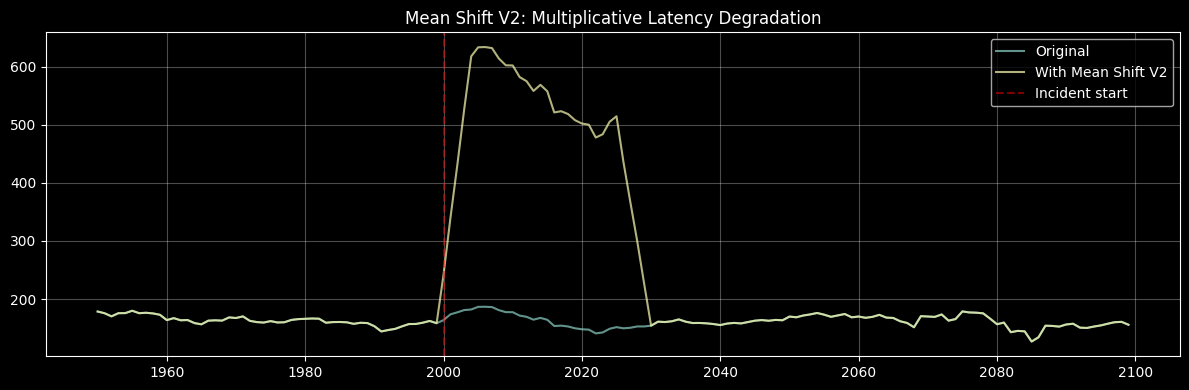

In [15]:
def inject_mean_shift_v2(metric_array, metric_name, start_idx, duration,
                         ramp_up_steps=5, ramp_down_steps=5):
    """
    - Magnitude relative to current value
    - Multiplicative for latency
    - Type-specific logic
    """
    modified = metric_array.copy()
    total_duration = ramp_up_steps + duration + ramp_down_steps

    if start_idx + total_duration > len(modified):
        return modified

    baseline_value = modified[start_idx]

    if metric_name in ['cpu_utilization', 'memory_usage']:
        # Additive: +25-40% of baseline
        magnitude = baseline_value * np.random.uniform(0.25, 0.40)
        is_multiplicative = False

    elif metric_name == 'error_rate':
        # Multiplicative: 3-10x increase
        multiplier = np.random.uniform(3.0, 10.0)
        is_multiplicative = True

    elif metric_name == 'request_latency':
        # MULTIPLICATIVE (realistic degradation)
        multiplier = np.random.uniform(1.8, 3.5)  # 1.8-3.5x increase
        is_multiplicative = True

    else:  # request_rate
        # Additive: +30-80% of baseline
        magnitude = baseline_value * np.random.uniform(0.30, 0.80)
        is_multiplicative = False


    for step in range(total_duration):
        idx = start_idx + step

        if step < ramp_up_steps:
            # Ramp-up phase
            progress = (step + 1) / ramp_up_steps  # 0 → 1
        elif step < ramp_up_steps + duration:
            # Plateau phase
            progress = 1.0
        else:
            # Ramp-down phase
            remaining = total_duration - step
            progress = remaining / ramp_down_steps  # 1 → 0

        if is_multiplicative:
            # Multiplicative: value × (1 + (multiplier-1) × progress)
            modified[idx] *= (1.0 + (multiplier - 1.0) * progress)
        else:
            # Additive: value + magnitude × progress
            modified[idx] += magnitude * progress

    return modified


# Test function
test_metric = df['request_latency'].values.copy()
test_modified = inject_mean_shift_v2(test_metric, 'request_latency',
                                     start_idx=2000, duration=20,
                                     ramp_up_steps=5, ramp_down_steps=5)

print("Mean Shift V2 Test:")
print(f"  Before (idx 2000): {test_metric[2000]:.2f} ms")
print(f"  Peak (idx ~2012): {test_modified[2012]:.2f} ms")
print(f"  After (idx 2030): {test_modified[2030]:.2f} ms")
print(f"  Peak multiplier: {test_modified[2012]/test_metric[2000]:.2f}x")

# Visualize test
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
window = slice(1950, 2100)
ax.plot(range(1950, 2100), test_metric[window], label='Original', alpha=0.7)
ax.plot(range(1950, 2100), test_modified[window], label='With Mean Shift V2', alpha=0.7)
ax.axvline(2000, color='red', linestyle='--', alpha=0.5, label='Incident start')
ax.set_title('Mean Shift V2: Multiplicative Latency Degradation')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Testing Heavy-Tailed Duration Distribution:
Generating 1000 incident durations...

Statistics:
  Min: 5 min
  Median: 12.0 min
  Mean: 16.4 min
  75th percentile: 21.0 min
  95th percentile: 43.0 min
  Max: 105 min


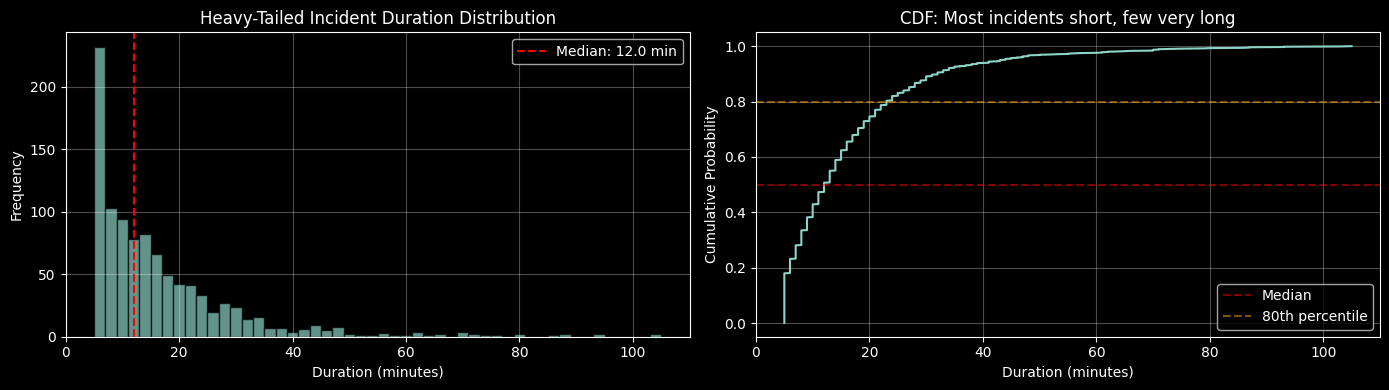


Heavy-tailed distribution: 80% incidents <20 min, rare incidents >60 min


In [16]:
def generate_incident_duration(incident_type='mean_shift'):
    """
    - Most incidents: short (5-20 min)
    - Some incidents: medium (20-40 min)
    - Rare incidents: long (1-3 hours)
    """
    if incident_type == 'point_anomaly':
        return np.random.choice([1, 2])

    else:  # mean_shift with heavy-tailed distribution
        # Lognormal parameters tuned for realistic cloud incidents
        # mean=2.5, sigma=0.8 gives:
        # - median ~12 min
        # - 75th percentile ~20 min
        # - 95th percentile ~40 min
        # - occasional outliers >60 min
        duration = int(np.random.lognormal(mean=2.5, sigma=0.8))

        # Clip to reasonable range: 5-180 min (3 hours max)
        duration = np.clip(duration, 5, 180)

        return duration


# Test distribution
print("Testing Heavy-Tailed Duration Distribution:")
print("Generating 1000 incident durations...\n")

durations = [generate_incident_duration('mean_shift') for _ in range(1000)]

print(f"Statistics:")
print(f"  Min: {np.min(durations)} min")
print(f"  Median: {np.median(durations):.1f} min")
print(f"  Mean: {np.mean(durations):.1f} min")
print(f"  75th percentile: {np.percentile(durations, 75):.1f} min")
print(f"  95th percentile: {np.percentile(durations, 95):.1f} min")
print(f"  Max: {np.max(durations)} min")

# Visualize distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Histogram
axes[0].hist(durations, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(np.median(durations), color='red', linestyle='--',
                label=f'Median: {np.median(durations):.1f} min')
axes[0].set_xlabel('Duration (minutes)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Heavy-Tailed Incident Duration Distribution')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Cumulative distribution
sorted_durations = np.sort(durations)
cumulative = np.arange(1, len(sorted_durations) + 1) / len(sorted_durations)
axes[1].plot(sorted_durations, cumulative)
axes[1].axhline(0.5, color='red', linestyle='--', alpha=0.5, label='Median')
axes[1].axhline(0.8, color='orange', linestyle='--', alpha=0.5, label='80th percentile')
axes[1].set_xlabel('Duration (minutes)')
axes[1].set_ylabel('Cumulative Probability')
axes[1].set_title('CDF: Most incidents short, few very long')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nHeavy-tailed distribution: 80% incidents <20 min, rare incidents >60 min")

In [17]:
# Define realistic incident scenarios with causal relationships and lags

INCIDENT_SCENARIOS = {
    'traffic_spike': {
        'description': 'Traffic surge → CPU load → Latency → Errors',
        'probability': 0.25,
        'affected_metrics': ['request_rate', 'cpu_utilization', 'request_latency', 'error_rate'],
        'lags': [0, 2, 5, 8],  # Minutes lag for each metric
        'direction': [1, 1, 1, 1]  # All UP
    },

    'backend_failure': {
        'description': 'Backend error → Latency spike → Traffic drop',
        'probability': 0.20,
        'affected_metrics': ['error_rate', 'request_latency', 'request_rate'],
        'lags': [0, 1, 3],
        'direction': [1, 1, -1]  # error↑, latency↑, traffic↓ (DOWN anomaly!)
    },

    'memory_leak': {
        'description': 'Memory grows → CPU pressure → Latency',
        'probability': 0.20,
        'affected_metrics': ['memory_usage', 'cpu_utilization', 'request_latency'],
        'lags': [0, 3, 6],
        'direction': [1, 1, 1]
    },

    'cpu_spike': {
        'description': 'CPU spike → Latency → Errors',
        'probability': 0.15,
        'affected_metrics': ['cpu_utilization', 'request_latency', 'error_rate'],
        'lags': [0, 2, 5],
        'direction': [1, 1, 1]
    },

    'service_crash': {
        'description': 'Process crash → CPU/Memory drop → Traffic zero → 100% errors',
        'probability': 0.10,
        'affected_metrics': ['cpu_utilization', 'memory_usage', 'request_rate', 'error_rate'],
        'lags': [0, 0, 1, 1],
        'direction': [-1, -1, -1, 1]  # DOWN anomalies for resources, UP for errors
    },

    'latency_only': {
        'description': 'Isolated latency spike (e.g., slow query)',
        'probability': 0.10,
        'affected_metrics': ['request_latency'],
        'lags': [0],
        'direction': [1]
    }
}

print("Defined 6 realistic incident scenarios:")
for scenario_name, config in INCIDENT_SCENARIOS.items():
    prob = config['probability'] * 100
    metrics = ', '.join(config['affected_metrics'])
    print(f"  [{prob:4.0f}%] {scenario_name:20s} - {config['description']}")

Defined 6 realistic incident scenarios:
  [  25%] traffic_spike        - Traffic surge → CPU load → Latency → Errors
  [  20%] backend_failure      - Backend error → Latency spike → Traffic drop
  [  20%] memory_leak          - Memory grows → CPU pressure → Latency
  [  15%] cpu_spike            - CPU spike → Latency → Errors
  [  10%] service_crash        - Process crash → CPU/Memory drop → Traffic zero → 100% errors
  [  10%] latency_only         - Isolated latency spike (e.g., slow query)


In [19]:
def inject_point_anomaly_down(metric_array, metric_name, start_idx):
    modified = metric_array.copy()
    duration = np.random.choice([1, 2])

    current_value = modified[start_idx]

    for i in range(duration):
        if start_idx + i >= len(modified):
            break

        if metric_name in ['cpu_utilization', 'memory_usage']:
            # Sharp drop: 60-90% reduction (process crash)
            multiplier = np.random.uniform(0.1, 0.4)  # Keep 10-40%
            modified[start_idx + i] *= multiplier

        elif metric_name == 'request_rate':
            # Traffic dropout: 70-95% reduction
            multiplier = np.random.uniform(0.05, 0.3)  # Keep 5-30%
            modified[start_idx + i] *= multiplier

        # error_rate and latency don't get DOWN anomalies in point spikes

    return modified


def inject_mean_shift_down(metric_array, metric_name, start_idx, duration,
                           ramp_up_steps=5, ramp_down_steps=5):
    modified = metric_array.copy()
    total_duration = ramp_up_steps + duration + ramp_down_steps

    if start_idx + total_duration >= len(modified):
        return modified

    baseline_value = modified[start_idx]

    if metric_name in ['cpu_utilization', 'memory_usage']:
        # Keep 15-40% of baseline
        target_multiplier = np.random.uniform(0.15, 0.40)
    elif metric_name == 'request_rate':
        # Keep 10-30% of baseline
        target_multiplier = np.random.uniform(0.10, 0.30)
    else:
        return modified  # No DOWN for error_rate/latency in mean shift

    # Apply pattern
    for step in range(total_duration):
        idx = start_idx + step

        if step < ramp_up_steps:
            # Ramp-down phase (declining)
            progress = (step + 1) / ramp_up_steps  # 0 → 1
        elif step < ramp_up_steps + duration:
            # Plateau phase (sustained low)
            progress = 1.0
        else:
            # Recovery phase
            remaining = total_duration - step
            progress = remaining / ramp_down_steps  # 1 → 0

        # Apply reduction: value × (1 - (1-target_multiplier) × progress)
        # When progress=1: value × target_multiplier
        # When progress=0: value × 1.0 (normal)
        modified[idx] *= (1.0 - (1.0 - target_multiplier) * progress)

    return modified


In [20]:
def inject_incidents_v2(df, target_incident_rate=0.015, min_spacing=50,
                        point_anomaly_ratio=0.3, cluster_ratio=0.2):

    df_modified = df.copy()
    n_timesteps = len(df)

    avg_incident_duration = 20  # Rough estimate
    n_incidents = int((target_incident_rate * n_timesteps) / avg_incident_duration)

    print(f"Injecting {n_incidents} incidents into {n_timesteps} timesteps")
    print(f"Target incident rate: {target_incident_rate*100:.1f}%")
    print(f"Cluster ratio: {cluster_ratio*100:.0f}% will be aftershocks")

    # Valid range (leave space for W and H)
    W, H = 60, 15
    valid_range = (W, n_timesteps - H - 200)  # Extra space for long incidents

    # Generate incident positions with clustering logic
    incident_positions = []
    is_cluster = []  # Track which incidents are clusters
    attempts = 0
    max_attempts = n_incidents * 20

    while len(incident_positions) < n_incidents and attempts < max_attempts:
        is_aftershock = (len(incident_positions) > 0 and
                         np.random.rand() < cluster_ratio)

        if is_aftershock:
            # Cluster: place near previous incident (5-20 min after)
            previous_pos = incident_positions[-1]
            pos = previous_pos + np.random.randint(5, 21)

            # Ensure within valid range
            if pos >= valid_range[1]:
                attempts += 1
                continue

            incident_positions.append(pos)
            is_cluster.append(True)

        else:
            pos = np.random.randint(valid_range[0], valid_range[1])

            if all(abs(pos - existing) >= min_spacing for existing in incident_positions):
                incident_positions.append(pos)
                is_cluster.append(False)

        attempts += 1

    incident_positions.sort()
    print(f"Generated {len(incident_positions)} incident positions")
    print(f"  Normal incidents: {sum(not x for x in is_cluster)}")
    print(f"  Cluster incidents: {sum(is_cluster)}")

    incident_intervals = []

    for incident_id, (start_idx, is_clustered) in enumerate(zip(incident_positions, is_cluster), start=1):

        is_point_anomaly = np.random.rand() < point_anomaly_ratio

        # Select scenario based on probabilities
        scenario_name = np.random.choice(
            list(INCIDENT_SCENARIOS.keys()),
            p=[s['probability'] for s in INCIDENT_SCENARIOS.values()]
        )
        scenario = INCIDENT_SCENARIOS[scenario_name]

        if is_point_anomaly:
            duration = generate_incident_duration('point_anomaly')
            end_idx = start_idx + duration
            incident_type_str = "Point"

        else:
            plateau_duration = generate_incident_duration('mean_shift')
            ramp_up = np.random.randint(3, 8)
            ramp_down = np.random.randint(3, 8)
            total_duration = ramp_up + plateau_duration + ramp_down
            end_idx = start_idx + total_duration
            incident_type_str = "MeanShift"

        if end_idx >= len(df_modified):
            continue

        for metric, lag, direction in zip(scenario['affected_metrics'],
                                          scenario['lags'],
                                          scenario['direction']):

            actual_start = start_idx + lag
            actual_end = end_idx + lag

            if actual_end >= len(df_modified):
                continue

            arr = df_modified[metric].to_numpy(copy=True)

            if is_point_anomaly:
                if direction == 1:  # UP anomaly
                    arr = inject_point_anomaly_v2(arr, metric, actual_start)
                else:  # DOWN anomaly
                    arr = inject_point_anomaly_down(arr, metric, actual_start)

            else:
                if direction == 1:  # UP anomaly
                    arr = inject_mean_shift_v2(arr, metric, actual_start,
                                              plateau_duration, ramp_up, ramp_down)
                else:  # DOWN anomaly
                    arr = inject_mean_shift_down(arr, metric, actual_start,
                                                 plateau_duration, ramp_up, ramp_down)

            df_modified.loc[:, metric] = arr

        cluster_tag = " [cluster]" if is_clustered else ""
        incident_intervals.append((start_idx, end_idx, incident_id, scenario_name))

        if incident_id <= 10:  # Print first 10
            print(f"  Inc {incident_id:2d}: {incident_type_str:9s} | {scenario_name:20s} | "
                  f"{start_idx:5d}→{end_idx:5d} ({end_idx-start_idx:3d} min){cluster_tag}")

    return df_modified, incident_intervals

print("   Features: causal scenarios, heavy-tailed duration, clusters, UP/DOWN anomalies")

   Features: causal scenarios, heavy-tailed duration, clusters, UP/DOWN anomalies


In [21]:
df_with_incidents_v2, incident_intervals_v2 = inject_incidents_v2(
    df,
    target_incident_rate=0.015,
    min_spacing=50,
    point_anomaly_ratio=0.3,  # 30% point, 70% mean shift
    cluster_ratio=0.2         # 20% clustered aftershocks
)

# Clip metrics after injection
df_with_incidents_v2['cpu_utilization'] = df_with_incidents_v2['cpu_utilization'].clip(0, 100)
df_with_incidents_v2['memory_usage'] = df_with_incidents_v2['memory_usage'].clip(0, 100)
df_with_incidents_v2['error_rate'] = df_with_incidents_v2['error_rate'].clip(0, 100)
df_with_incidents_v2['request_latency'] = df_with_incidents_v2['request_latency'].clip(0, None)
df_with_incidents_v2['request_rate'] = df_with_incidents_v2['request_rate'].clip(0, None)

print(f"\nMetric ranges (after incidents):")
for metric in ['cpu_utilization', 'memory_usage', 'request_latency', 'error_rate', 'request_rate']:
    print(f"  {metric}: [{df_with_incidents_v2[metric].min():.2f}, {df_with_incidents_v2[metric].max():.2f}]")

Injecting 15 incidents into 20000 timesteps
Target incident rate: 1.5%
Cluster ratio: 20% will be aftershocks
Generated 15 incident positions
  Normal incidents: 13
  Cluster incidents: 2
  Inc  1: MeanShift | backend_failure      |  1461→ 1481 ( 20 min)
  Inc  2: MeanShift | memory_leak          |  2805→ 2823 ( 18 min)
  Inc  3: MeanShift | memory_leak          |  4085→ 4100 ( 15 min)
  Inc  4: Point     | latency_only         |  6215→ 6217 (  2 min)
  Inc  5: MeanShift | service_crash        |  6230→ 6249 ( 19 min)
  Inc  6: MeanShift | memory_leak          | 10764→10780 ( 16 min)
  Inc  7: MeanShift | cpu_spike            | 12016→12033 ( 17 min) [cluster]
  Inc  8: MeanShift | service_crash        | 12035→12053 ( 18 min)
  Inc  9: MeanShift | memory_leak          | 12156→12181 ( 25 min)
  Inc 10: MeanShift | traffic_spike        | 12572→12586 ( 14 min)

Metric ranges (after incidents):
  cpu_utilization: [12.25, 86.90]
  memory_usage: [11.20, 94.52]
  request_latency: [67.20, 674.37

In [22]:
def create_incident_labels(n_timesteps, incident_intervals):
    labels = np.zeros(n_timesteps, dtype=int)

    for start, end, incident_id, scenario in incident_intervals:
        labels[start:end] = 1

    return labels


incident_labels_v2 = create_incident_labels(len(df_with_incidents_v2), incident_intervals_v2)
df_with_incidents_v2['incident_label'] = incident_labels_v2

print(f"Label distribution:")
print(f"  Normal (0): {(incident_labels_v2 == 0).sum():5d} timesteps ({(incident_labels_v2 == 0).sum()/len(incident_labels_v2)*100:.2f}%)")
print(f"  Incident (1): {(incident_labels_v2 == 1).sum():5d} timesteps ({(incident_labels_v2 == 1).sum()/len(incident_labels_v2)*100:.2f}%)")

print(f"\nDataFrame shape: {df_with_incidents_v2.shape}")
print(f"Total incidents: {len(incident_intervals_v2)}")

Label distribution:
  Normal (0): 19518 timesteps (97.59%)
  Incident (1):   482 timesteps (2.41%)

DataFrame shape: (20000, 7)
Total incidents: 15


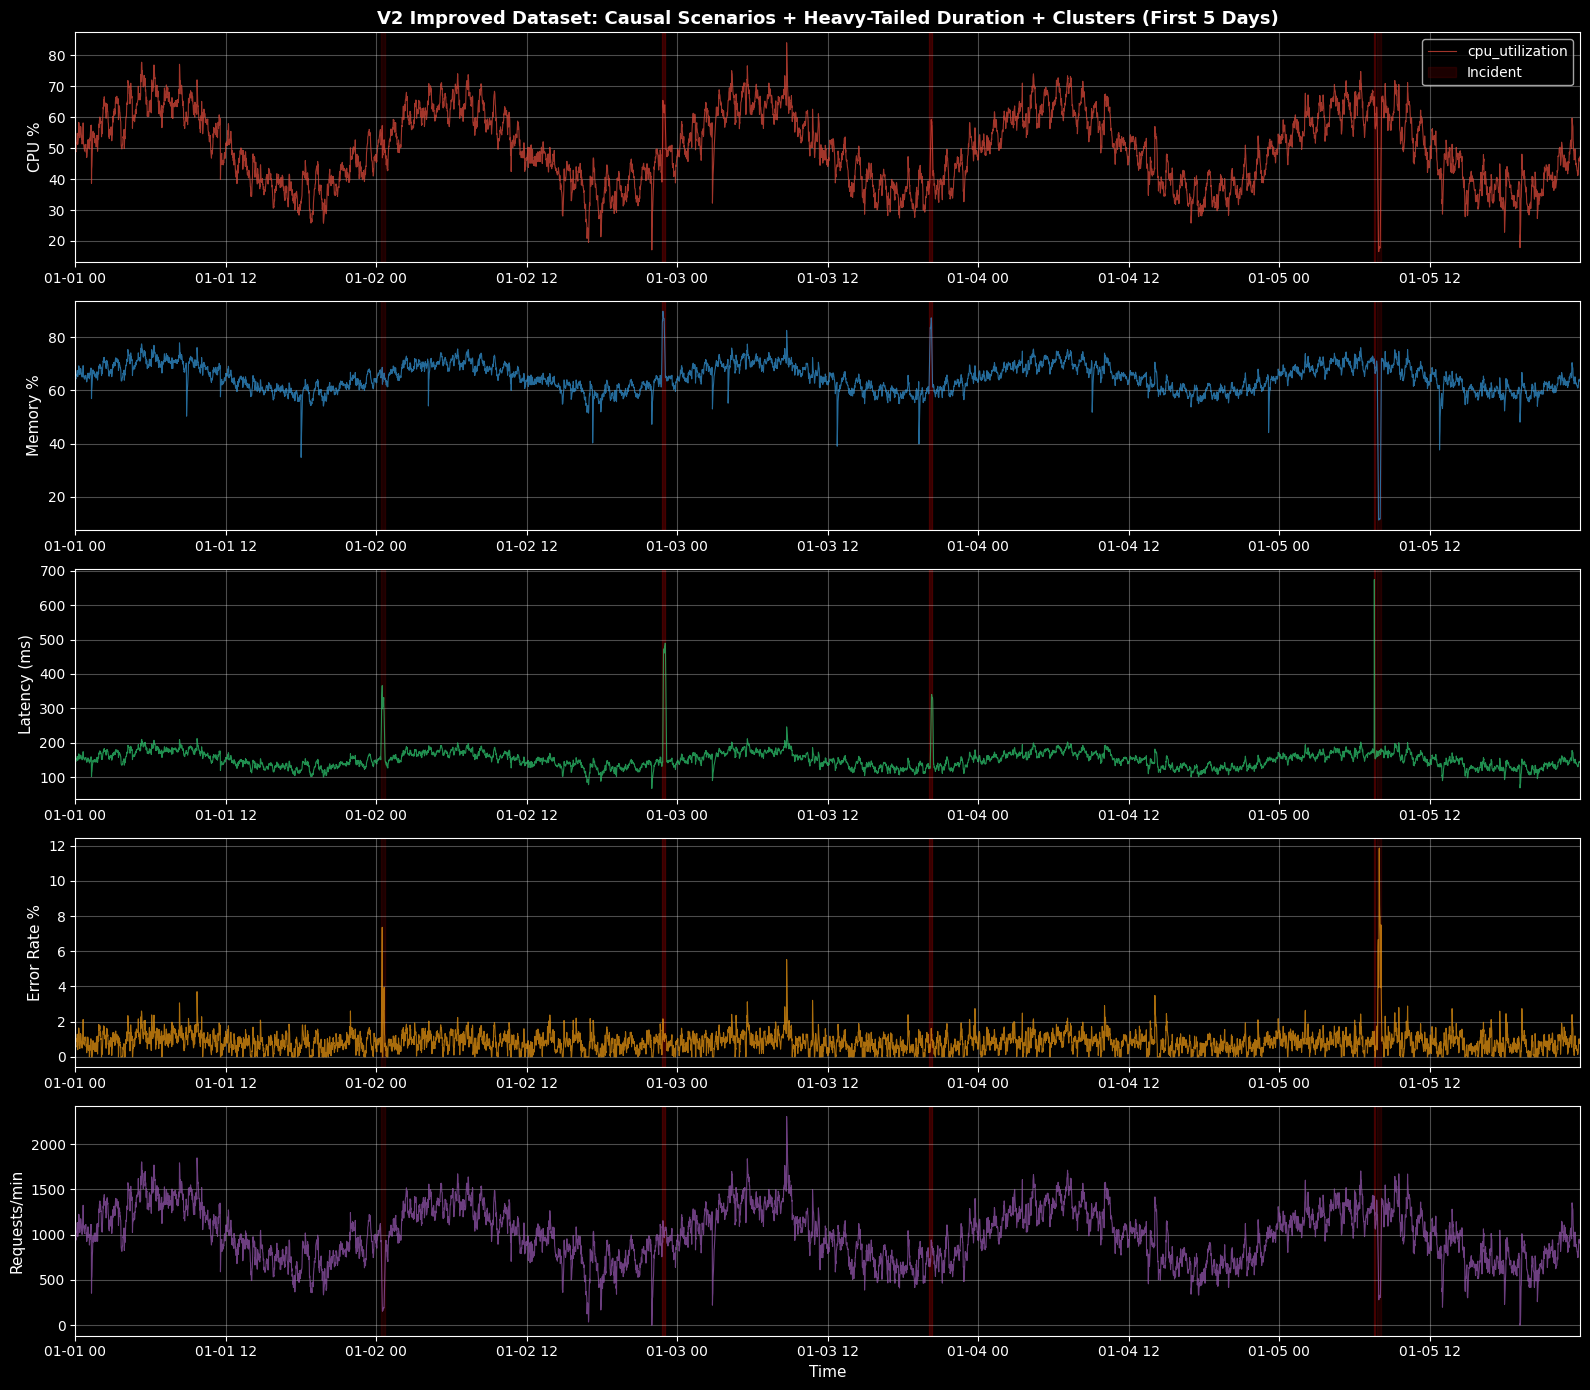


Incidents in displayed window (first 7200 timesteps):
  Inc  1 [backend_failure     ]: 2026-01-02 00:21:00 → 2026-01-02 00:41:00 ( 20 min)
  Inc  2 [memory_leak         ]: 2026-01-02 22:45:00 → 2026-01-02 23:03:00 ( 18 min)
  Inc  3 [memory_leak         ]: 2026-01-03 20:05:00 → 2026-01-03 20:20:00 ( 15 min)
  Inc  4 [latency_only        ]: 2026-01-05 07:35:00 → 2026-01-05 07:37:00 (  2 min)
  Inc  5 [service_crash       ]: 2026-01-05 07:50:00 → 2026-01-05 08:09:00 ( 19 min)


In [23]:
fig, axes = plt.subplots(5, 1, figsize=(16, 14))

n_show = 1440 * 5  # 5 days

metrics = ['cpu_utilization', 'memory_usage', 'request_latency', 'error_rate', 'request_rate']
colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6']
ylabels = ['CPU %', 'Memory %', 'Latency (ms)', 'Error Rate %', 'Requests/min']

for idx, (metric, color, ylabel) in enumerate(zip(metrics, colors, ylabels)):
    axes[idx].plot(df_with_incidents_v2['timestamp'][:n_show],
                   df_with_incidents_v2[metric][:n_show],
                   color=color, alpha=0.7, linewidth=0.8, label=metric)

    # Highlight incident intervals
    for start, end, inc_id, scenario in incident_intervals_v2:
        if start < n_show:
            # Color code by scenario type
            if 'crash' in scenario or 'failure' in scenario:
                incident_color = 'darkred'  # Critical scenarios
            elif 'spike' in scenario:
                incident_color = 'orange'   # Traffic/CPU spikes
            else:
                incident_color = 'red'      # Other incidents

            axes[idx].axvspan(df_with_incidents_v2['timestamp'].iloc[start],
                            df_with_incidents_v2['timestamp'].iloc[min(end, n_show-1)],
                            alpha=0.2, color=incident_color,
                            label='Incident' if start == incident_intervals_v2[0][0] else '')

    axes[idx].set_ylabel(ylabel, fontsize=11)
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_xlim(df_with_incidents_v2['timestamp'].iloc[0],
                      df_with_incidents_v2['timestamp'].iloc[n_show-1])

    if idx == 0:
        axes[idx].legend(loc='upper right')

axes[4].set_xlabel('Time', fontsize=11)
axes[0].set_title('V2 Improved Dataset: Causal Scenarios + Heavy-Tailed Duration + Clusters (First 5 Days)',
                  fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nIncidents in displayed window (first {n_show} timesteps):")
for start, end, inc_id, scenario in incident_intervals_v2[:10]:
    if start < n_show:
        duration = end - start
        print(f"  Inc {inc_id:2d} [{scenario:20s}]: {df_with_incidents_v2['timestamp'].iloc[start]} → "
              f"{df_with_incidents_v2['timestamp'].iloc[min(end, n_show-1)]} ({duration:3d} min)")

In [ ]:
import json
from collections import Counter

df_with_incidents_v2.to_csv("../data/synthetic_data_v2_improved.csv", index=False)

coverage = int((df_with_incidents_v2["incident_label"] == 1).sum())
rate = coverage / len(df_with_incidents_v2) * 100

print(f"Saved CSV: data/synthetic_data_v2_improved.csv | shape={df_with_incidents_v2.shape} | "
      f"incidents={len(incident_intervals_v2)} | rate={rate:.2f}%")

intervals_with_metadata = []
for start, end, inc_id, scenario in incident_intervals_v2:
    sc = INCIDENT_SCENARIOS.get(scenario, {})

    intervals_with_metadata.append({
        "incident_id": int(inc_id),
        "start_idx": int(start),
        "end_idx": int(end),
        "duration_min": int(end - start),
        "scenario": str(scenario),
        "scenario_description": sc.get("description", ""),
        "affected_metrics": list(sc.get("affected_metrics", [])),
        "lags": [int(x) for x in sc.get("lags", [])],
    })

with open("../src/incident_intervals_v2_improved.json", "w", encoding="utf-8") as f:
    json.dump(intervals_with_metadata, f, indent=2, ensure_ascii=False)

print(f"Saved JSON: incident_intervals_v2_improved.json | rows={len(intervals_with_metadata)}")

durations = np.array([int(e - s) for s, e, _, _ in incident_intervals_v2], dtype=int)
scenario_counts = Counter([str(scn) for _, _, _, scn in incident_intervals_v2])

top3 = ", ".join([f"{k}:{v}" for k, v in scenario_counts.most_common(3)])
print(f"Coverage={coverage} timesteps | Dur(min/med/mean/p95/max)="
      f"{durations.min()}/{int(np.median(durations))}/{durations.mean():.1f}/"
      f"{int(np.percentile(durations,95))}/{durations.max()} | Top3 scenarios: {top3}")
